In [1]:
from pathlib import Path
import re
from itertools import product

import lxml.etree as ET
import pandas as pd
import plotnine as p9
from tqdm import tqdm_notebook

In [2]:
biorxiv_files = Path("../biorxiv_articles").rglob("*.xml")

In [3]:
article_metadata = []
article_sections = []

type_mapper = {
    'author-type':'author_type',
    'heading':'heading',
    'hwp-journal-coll':'category'
}

for file in tqdm_notebook(biorxiv_files):
    article = file.with_suffix('').name
    root = ET.parse(open(file, "rb")).getroot()
    
    # Grab the subject category
    metadata = {
        type_mapper[x.attrib['subj-group-type']]:x.getchildren()[0].text.lower()
        for x in root.xpath('//subj-group')
    }
    metadata.update({'document':f"{article}.xml", 'doi':root.xpath('//article-id')[0].text})
    article_metadata.append(metadata)
    
    # Grab the section titles 
    section_objs = list(filter(lambda x: "id" in x.attrib and re.search(r"s[\d]+$", x.attrib['id']) is not None, root.xpath('//sec')))
    title_objs = list(map(lambda x: x.xpath('title//text()'), section_objs))
    title_objs = list(filter(lambda x: len(x) > 0, title_objs))
    
    # edge case in the xml where
    # a tag contains the following: <title>A<sc>bstract</sc></title>
    # why is there a <sc> tag?
    if any(list(map(lambda x: len(x) > 1, title_objs))):
        # filter out weird characters ⓘ
        # cant think of a better way to handle these types of edge cases
        title_objs = list(map(lambda headers: list(filter(lambda token: token != 'ⓘ', headers)), title_objs))
        title_objs = list(map(lambda x: x[0] + x[1] if len(x) > 1 else x, title_objs))
    
    abstract_section = root.xpath('//abstract/title//text()')
    if len(abstract_section) > 0:
        
        # in case of a parse error that splits A from bstract
        if len(abstract_section) > 1:
            abstract_section = ["".join(abstract_section)]
        
        title_objs = title_objs + [abstract_section]

    title_objs = list(map(lambda x: x[0].rstrip().lower(), title_objs))
    article_sections += list(map(lambda x: {'section':x[0],  'document':x[1]}, product(title_objs, [article])))

In [4]:
metadata_df = (
    pd.DataFrame
    .from_records(article_metadata)
    .fillna({"category":'none', 'author_type':'none', 'heading':'none'})
    .assign(category=lambda x:x.category.apply(lambda x: " ".join(x.split("_")) if "_" in x else x))
)

metadata_df.to_csv("output/biorxiv_article_metadata.tsv", sep="\t", index=False)
metadata_df.head()

,author_type,heading,category,document,doi
0,regular article,new results,genetics,227082.xml,10.1101/227082
1,regular article,new results,neuroscience,177188.xml,10.1101/177188
2,regular article,new results,biophysics,172809.xml,10.1101/172809
3,regular article,new results,genomics,534040.xml,10.1101/534040
4,regular article,new results,molecular biology,554410.xml,10.1101/554410


In [5]:
sections_df = (
    pd.DataFrame
    .from_records(article_sections)
)

sections_df.to_csv("output/biorxiv_article_sections.tsv", sep="\t", index=False)
sections_df.head()

,section,document
0,model and methods,227082
1,results,227082
2,discussion,227082
3,abstract,227082
4,introduction,177188


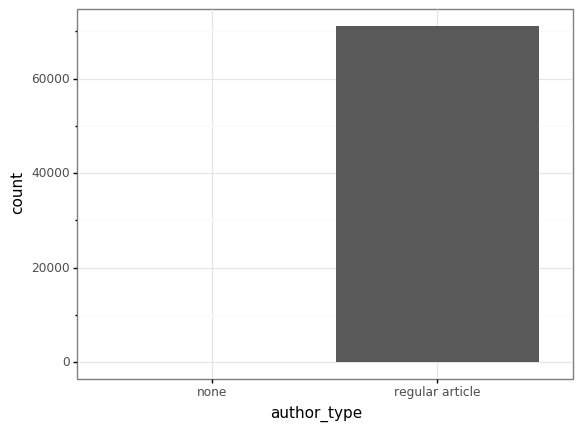

<ggplot: (-9223363245554163326)>


In [6]:
g = (
    p9.ggplot(metadata_df, p9.aes(x="author_type"))
    + p9.geom_bar(size=10)
    + p9.theme_bw()
)
print(g)

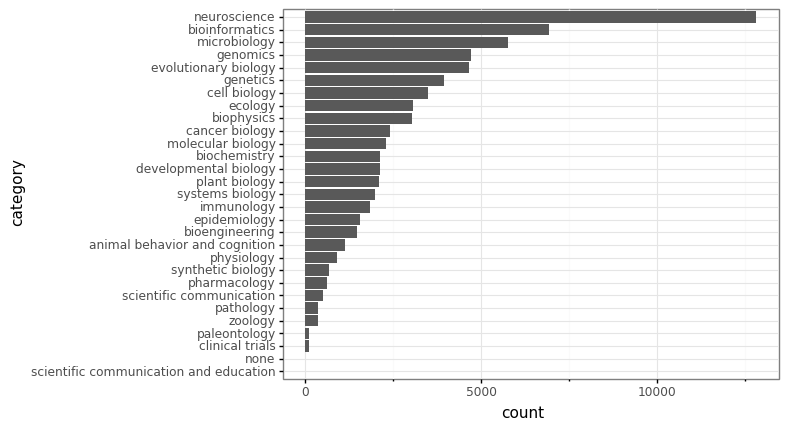

<ggplot: (8791294272376)>


In [7]:
category_list = metadata_df.category.value_counts().index.tolist()[::-1]

# plot nine doesn't implement reverse keyword for scale x discrete
# ugh...
g = (
    p9.ggplot(metadata_df, p9.aes(x="category"))
    + p9.geom_bar(size=10)
    + p9.scale_x_discrete(limits=category_list)
    + p9.coord_flip()
    + p9.theme_bw()
)
print(g)

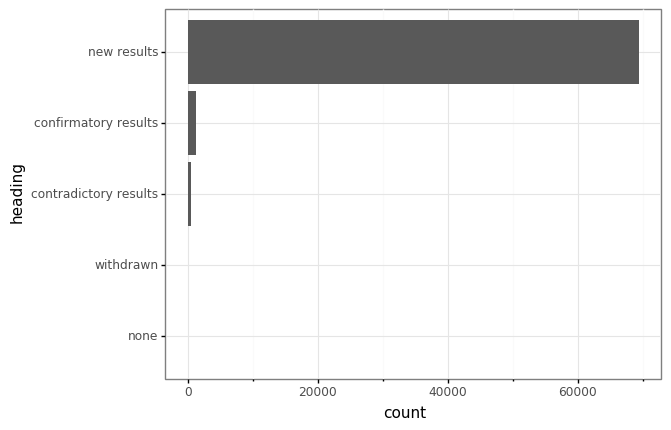

<ggplot: (8791299645132)>


In [8]:
heading_list = metadata_df.heading.value_counts().index.tolist()[::-1]

g = (
    p9.ggplot(metadata_df, p9.aes(x="heading"))
    + p9.geom_bar(size=10)
    + p9.scale_x_discrete(limits=heading_list)
    + p9.coord_flip()
    + p9.theme_bw()
)
print(g)

In [26]:
def header_mapper(header):
    if "method" in header:
        return "material and methods"
    if "abstract" in header:
        return "abstract"
    if "conclusion" in header:
        return "conclusion"
    return header

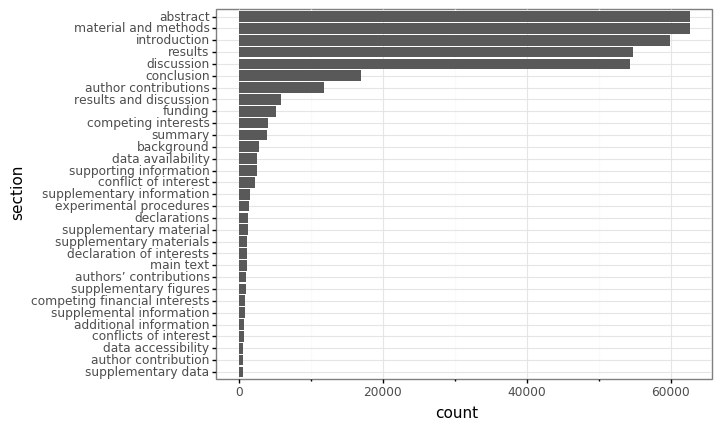

<ggplot: (8791294642331)>


In [27]:
sections_df = (
    sections_df
    .assign(
        section=lambda x: x.section.apply(
            lambda y: header_mapper(y)
        )
    )
)

section_list = sections_df.section.value_counts()
section_list = section_list[section_list > 500].index.to_list()[::-1]

g = (
    p9.ggplot(sections_df[sections_df.section.isin(section_list)])
    + p9.aes(x="section")
    + p9.geom_bar()
    + p9.scale_x_discrete(limits=section_list)
    + p9.coord_flip()
    + p9.theme_bw()
)
print(g)